* 아래 함수는 `weather_localcenter_metadata`와 `weather_5minute_ASOS_2020-2023.parquet`, `holiday.csv`를 사용하여 5분 단위 기상대표값을 도출합니다.
* 본 모델링에서는 기상인자로 최고기온, 최저기온, 평균일사량 데이터를 사용하고자 합니다. 일사량의 결측치 비율을 최소화 하기 위해 울산시를 제외한 특별시 및 광역시 데이터를 사용하였으며 (울산시 일사량 데이터의 대부분이 결측치였음), 강원도의 기상 인자도 반영하기 위해 도내에서 가장 인구가 많은 도시인 원주를 포함하였습니다.
* 보간법을 적용하기 전의 기온과 일사량의 결측치 비율은 전체 대비 0.2%, 0.4% 수준이며, 선형보간법을 통해 결측치를 보완하고자 했습니다.
* 단순히 휴일여부가 아니라 어떤 휴일에 해당하는지를 더미변수로 추가해보았습니다. (휴일이 아닌 날, 신정, 설날, 삼일절, 선거일, 어린이날, 석가탄신일, 현충일, 광복절, 추석, 개천절, 기독탄신일, 한글날, 대체공휴일 등 총 14가지로 분류)

In [2]:
def weather_data_5minute(weather_metadata_path, weather_5minute_ASOS_path, holiday_path):

  import pandas as pd

  # 기상관측 MetaData 불러오기
  weather_metadata = pd.read_csv(weather_metadata_path)
  STN_dict = {STN_name : STN_num for STN_num, STN_name in zip(weather_metadata['지점'], weather_metadata['지점명'])}
  target_STN_list = [STN_dict[STN_name] for STN_name in ['서울', '부산', '인천', '대구', '대전', '광주', '원주']]

  # 서울 포함 7개 도시의 기온 및 일사량 데이터 불러오기
  weather_5minute = pd.read_parquet(weather_5minute_ASOS_path).astype({'지점' : 'int'})
  weather_5minute = weather_5minute[weather_5minute['지점'].isin(target_STN_list)]
  weather_5minute = weather_5minute[['지점', '일시', '기온(°C)', '일사(MJ/m^2)']]
  weather_5minute.columns = ['지점', '일시', '기온', '일사']

  column_list = ['기온', '일사']

  # 선형보간법 사용하여 결측값 채우기
  for idx, STN in enumerate(target_STN_list):

      # ① 각 STN별로 데이터 나누기
      tmp = weather_5minute[weather_5minute['지점'] == STN]

      # ② 시간순으로 정렬하기
      tmp = tmp.sort_values(by='일시')

      # ③ 선형보간법을 사용하여 nan값 채우기                
      for column in column_list:
        tmp[column] = tmp[column].interpolate(method='linear')

      # ④ tmp 합치기
      if idx == 0:
        interpolated_weather = tmp
      else:
        interpolated_weather = pd.concat([interpolated_weather, tmp])

  # 전국 기상 대표값 정하기 (최고기온, 최저기온, 평균일사량)
  for idx, column in enumerate(column_list):
    if column == '기온':
      # 최고 기온
      tmp_1 = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].max()).rename(columns = {'기온' : 'max_temp'})
      # 최저 기온
      tmp_2 = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].min()).rename(columns = {'기온' : 'min_temp'})
      tmp = pd.merge(tmp_1, tmp_2, on = '일시', how = 'inner')
    else:
      # 평균 일사량
      tmp = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].mean()).rename(columns = {'일사' : 'mean_insolation'})
    # ② groupby 결과를 인덱스 기준으로 Join
    if idx == 0:
      representative_weather = tmp
    else:
      representative_weather = pd.merge(representative_weather, tmp, on = '일시', how = 'inner')

  representative_weather.rename(columns = {'일시' : 'datetime'}, inplace= True)

  # 요일 특성 반영 (더미변수로 반영)
  # 0 : 월요일, 1 : 화요일 ~ 금요일, 2 : 토요일, 3 : 일요일

  representative_weather['weekday'] = pd.to_datetime(representative_weather['datetime']).dt.weekday
  representative_weather.replace({'weekday' : {2 : 1, 3 : 1, 4 : 1, 5 : 2, 6 : 3}}, inplace = True)
  representative_weather = pd.get_dummies(representative_weather, columns = ['weekday'])
                                          
  # 휴일 유형에 맞춘 더미변수 반영

  holiday = pd.read_csv(holiday_path)

  for dateName in ['국회의원선거일', '대통령선거일', '동시지방선거일', '전국동시지방선거', '제21대 국회의원선거']:
    holiday.replace({'dateName' : {dateName : '선거일'}}, inplace = True)
  holiday.replace({'dateName' : {'1월1일' : '신정'}}, inplace = True)
  holiday.replace({'dateName' : {'부처님오신날' : '석가탄신일'}}, inplace = True)
  holiday.replace({'dateName' : {'어린이 날' : '어린이날'}}, inplace = True)
  holiday.replace({'dateName' : {'대체휴무일' : '대체공휴일'}}, inplace = True)
  holiday.replace({'dateName' : {'임시공휴일' : '대체공휴일'}}, inplace = True)

  nameToNumber = {dateName : idx + 1  for idx, dateName in enumerate(list(holiday['dateName'].unique()))}
  holiday.replace({'dateName' : nameToNumber}, inplace = True)
  holiday_dict = {locdate : dateName for dateName, locdate in zip(holiday['dateName'], holiday['locdate'])}

  for row_number in range(representative_weather.shape[0]):
    if representative_weather.at[row_number, 'datetime'][:-6] in list(holiday['locdate']):
      representative_weather.at[row_number, 'holiday'] = holiday_dict[representative_weather.at[row_number, 'datetime'][:-6]]
    else:
      representative_weather.at[row_number, 'holiday'] = 0

  representative_weather = pd.get_dummies(representative_weather, columns = ['holiday'])

  # 월, 시간 정보 반영 (더미변수로 반영)

  representative_weather['month'] = pd.to_datetime(representative_weather['datetime']).dt.month
  representative_weather = pd.get_dummies(representative_weather, columns = ['month'])
  representative_weather['hour'] = pd.to_datetime(representative_weather['datetime']).dt.hour
  representative_weather = pd.get_dummies(representative_weather, columns = ['hour'])

  return representative_weather

In [3]:
# 기상대표값 데이터 생성하기

weather_metadata_path = '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/weather/weather_localcenter_metadata.csv'
weather_5minute_ASOS_path = '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/weather/ASOS (2020-2023)/weather_5minute_ASOS_2020-2023.parquet'
holiday_path = '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/time/holidays.csv'
representative_weather = weather_data_5minute(weather_metadata_path, weather_5minute_ASOS_path, holiday_path)

전력 데이터는 지호님이 완성해주신 `power_demand_interpolated`를 사용하였습니다.

In [4]:
# 전력 데이터 불러오기

import pandas as pd

power = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/load_supply/power_demand_interpolated.csv')
power.columns = ['datetime', 'load']

기상인자 대표값과 보간 처리된 전력데이터를 일시를 기준으로 Inner Join합니다.

In [5]:
# 전력 데이터와 기상인자 데이터 합치기

target_df = pd.merge(representative_weather, power, on = 'datetime', how = 'inner')

Custom Dataset과 Dataloader를 사용하여 메모리 사용량을 줄였습니다.

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, target_df, binary_var_start_number, scaler_for_X, scaler_for_Y, seq_len, step_len, stride):
    self.dataset_tensor =torch.FloatTensor(np.array(pd.concat([pd.DataFrame(scaler_for_X.fit_transform(target_df.iloc[:,1:binary_var_start_number])),
                                                               target_df.iloc[:,binary_var_start_number:-1],
                                                               pd.DataFrame(scaler_for_Y.fit_transform(np.array(target_df['load']).reshape(-1, 1)))], axis = 1))).cuda()                           
    self.data_size = (self.dataset_tensor.shape[0] - step_len - seq_len) // stride
    self.seq_len = seq_len
    self.step_len = step_len
    self.stride= stride
  
  def __len__(self):
    return self.data_size
  
  def __getitem__(self, idx):
    return self.dataset_tensor[idx*self.stride :idx*self.stride + self.seq_len, :], self.dataset_tensor[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len, -1]

# Scaler 객체 생성
ss_1 = MinMaxScaler() # Scaler for X
ss_2 = MinMaxScaler() # Scaler for y

# CustomDataset 파라미터 설정 (Scaler 객체, 시퀀스의 길이, 스텝 사이즈, 건너뛸 간격)
seq_len = 2016 # 시퀀스의 길이
step_len = 72 # 스텝 사이즈 (추정하고자 하는 값의 개수)
stride = 1 # 건너뛸 간격

# 데이터셋 생성
dataset = CustomDataset(target_df, 4, ss_1, ss_2, seq_len, step_len, stride)

# 학습용, 테스트용 데이터셋 분리
train_size = int(round(len(dataset) * 0.8))
train_dataset = Subset(dataset, [i for i in range(train_size)])
test_dataset = Subset(dataset, [i for i in range(train_size, len(dataset))])

# 데이터 로더 생성
train_dataloader = DataLoader(train_dataset, batch_size = 256, shuffle = True, drop_last = True)
val_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = True, drop_last = True)

In [11]:
import torch.nn as nn

# 모델 구성하기

input_dim = 58 # 입력 컬럼의 개수
hidden_dim = 288 # 은닉 상태의 개수
output_dim = 72 # 출력 값의 개수(형태)
learning_rate = 0.0001 # 학습률
nb_epochs = 30 # 에포크의 수
seq_length = 2016 # sequence의 길이 (얼마간의 데이터가 들어오는가)

class Net(nn.Module):
  def __init__(self, input_dim, hidden_dim, seq_len, out_dim, layers):
    super(Net, self).__init__()
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.output_dim = output_dim
    self.layers = layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_dim, bias = True)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.layers, self.seq_len, self.hidden_dim)
    )
  
  def forward(self, x):
    x, _status = self.lstm(x)
    x = self.fc(x[:, -1])
    return x

In [9]:
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 20.2 MB/s eta 0:00:00


In [10]:
# 모델 학습 함수 만들기

# !pip install torchmetrics
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from torchmetrics import MeanAbsolutePercentageError

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  nb_epochs = num_epochs
  mean_abs_percentage_error = MeanAbsolutePercentageError().to(device)

  # epoch마다 loss 저장
  train_hist = np.zeros(nb_epochs)
  output = []
  
  for epoch in range(nb_epochs):
    avg_cost = 0
    total_batch = len(train_df)
    for batch_idx, samples in enumerate(train_df):
      x_train, y_train = samples
      # seq별 hidden state reset
      model.reset_hidden_state()
      # H(x) 계산
      outputs = model(x_train)
      # cost 계산
      loss = mean_abs_percentage_error(outputs, y_train)
      # cost로 H(x) 개선
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      avg_cost += loss/total_batch 

    train_hist[epoch] = avg_cost

    if epoch % verbose == 0:
      print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
    # patience번째 마다 early stopping 여부 확인
    if (epoch % patience == 0) & (epoch != 0):
      if train_hist[epoch-patience] < train_hist[epoch]:
        print('\n Early Stopping')
        break
  
  return model.eval(), train_hist

In [12]:
# 모델 학습 (LSTM layer를 2개로 설정하였습니다.)

net = Net(input_dim, hidden_dim, seq_length, output_dim, 2).to(device)
model, train_hist = train_model(net, train_dataloader, num_epochs = nb_epochs,
                                lr = learning_rate, verbose = 1, patience = 4)

Epoch: 0000 train loss : 0.3265
Epoch: 0001 train loss : 0.1778
Epoch: 0002 train loss : 0.1307
Epoch: 0003 train loss : 0.1228
Epoch: 0004 train loss : 0.1067
Epoch: 0005 train loss : 0.1044
Epoch: 0006 train loss : 0.1022
Epoch: 0007 train loss : 0.0894
Epoch: 0008 train loss : 0.0948
Epoch: 0009 train loss : 0.0855
Epoch: 0010 train loss : 0.0825
Epoch: 0011 train loss : 0.0826
Epoch: 0012 train loss : 0.0752
Epoch: 0013 train loss : 0.0783
Epoch: 0014 train loss : 0.0813
Epoch: 0015 train loss : 0.0711
Epoch: 0016 train loss : 0.0719
Epoch: 0017 train loss : 0.0706
Epoch: 0018 train loss : 0.0687
Epoch: 0019 train loss : 0.0661
Epoch: 0020 train loss : 0.0654
Epoch: 0021 train loss : 0.0637
Epoch: 0022 train loss : 0.0644
Epoch: 0023 train loss : 0.0625
Epoch: 0024 train loss : 0.0610
Epoch: 0025 train loss : 0.0593
Epoch: 0026 train loss : 0.0586
Epoch: 0027 train loss : 0.0582
Epoch: 0028 train loss : 0.0590
Epoch: 0029 train loss : 0.0571


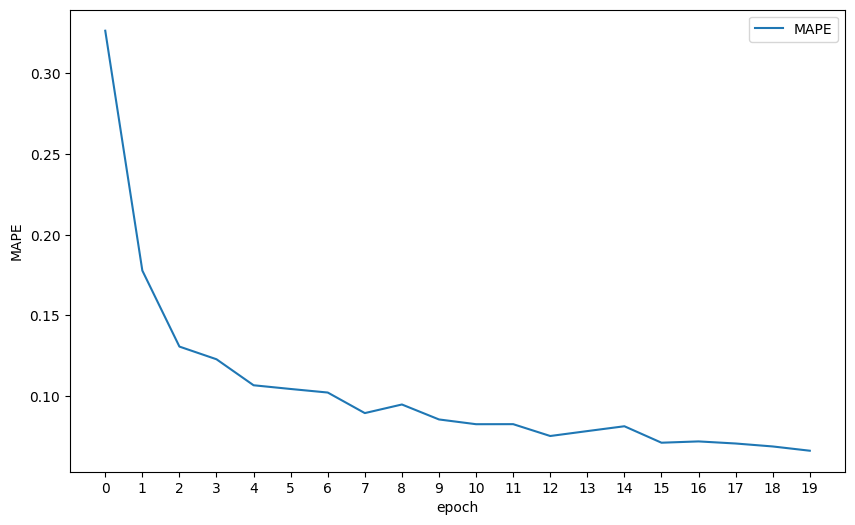

In [15]:
# 학습 중 MAPE 추이 확인

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,6))
plt.plot(train_hist[:20], label = 'MAPE')
plt.xlabel('epoch')
plt.xticks([i for i in range(0, 20)])
plt.ylabel('MAPE')
plt.legend()
plt.show()

In [18]:
torch.save(model,'/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/modeling/모델링 결과/model_20230524.pth')

In [ ]:
# 모델 검증

def MAPE(true, pred):
    return np.mean(np.abs((true-pred)/true))

with torch.no_grad():
  MAPE_list = []
  pred_list = []
  true_list = []
  for X, y in val_dataloader:
    # 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)
    pred = model(X)
    # Scaler로 원래 값으로 돌려놓기
    pred_inverse = ss_2.inverse_transform(np.array(pred.cpu()))
    testY_inverse = ss_2.inverse_transform(y.to('cpu'))
    pred_list.append(pred_inverse)
    true_list.append(testY_inverse)
    # Calculate MAPE
    MAPE_list.append(round(MAPE(testY_inverse, pred_inverse)*100, 3))

In [24]:
print('평균 MAPE는 {}% 입니다'.format(round(sum(MAPE_list) / len(MAPE_list), 3)))

평균 MAPE는 2.032% 입니다


In [31]:
# 무작위하게 고른 샘플의 백분율 오차 확인

np.abs(pred_list[265][0] - true_list[265][0])/ true_list[265][0]

array([0.00785129, 0.01150221, 0.01864381, 0.01176486, 0.01443798,
       0.00690405, 0.01199496, 0.01287198, 0.01580491, 0.01615904,
       0.01503399, 0.01542164, 0.0219139 , 0.02158018, 0.02634345,
       0.02750166, 0.02536088, 0.03027963, 0.02698883, 0.02259848,
       0.02610299, 0.02871602, 0.0326577 , 0.03033238, 0.03243239,
       0.03008678, 0.03105696, 0.02743406, 0.0311123 , 0.01866494,
       0.0155899 , 0.01272868, 0.01533396, 0.00750443, 0.01343006,
       0.01716225, 0.01438663, 0.01562203, 0.01082996, 0.01067865,
       0.01673973, 0.01480862, 0.01329114, 0.01725515, 0.01816872,
       0.02589381, 0.02404968, 0.03073008, 0.02897428, 0.03340532,
       0.02932064, 0.03330176, 0.03405737, 0.03200913, 0.03459882,
       0.02458691, 0.02893644, 0.02624798, 0.03386314, 0.03490746,
       0.03506253, 0.0356376 , 0.03003298, 0.03392328, 0.02745842,
       0.03151609, 0.02762195, 0.02502045, 0.03004228, 0.02518353,
       0.04078542, 0.0321169 ])